id -각 트윗에 대한 고유 식별자

text -트윗의 텍스트

location -트윗을 보낸 위치 (비어있을 수 있음)

keyword -트윗의 특정 키워드 (비어있을 수 있음)

target-에서 train.csv 만 트윗 실제 재해 인지 (1) 또는 아니면 (0)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit 
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
cf.go_offline()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
print(train.isnull().sum())
print("합계 : ",train.isnull().sum().sum())
print("="*40)
print(test.isnull().sum())
print("합계 : ",test.isnull().sum().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
합계 :  2594
id             0
keyword       26
location    1105
text           0
dtype: int64
합계 :  1131


In [ ]:
train['text'].nunique(),train['target'].nunique()#중복된 샘플이 몇개인지 확인

(7503, 2)

In [ ]:
print("중복제거하기 전 개수:",len(train))
train.drop_duplicates(subset="text",inplace=True)
print("중복제거 후 개수:",len(train))
print("="*40)
print("중복제거하기 전 개수:",len(test))
train.drop_duplicates(subset="text",inplace=True)
print("중복제거 후 개수:",len(test))

중복제거하기 전 개수: 7613
중복제거 후 개수: 7503
중복제거하기 전 개수: 3263
중복제거 후 개수: 3263


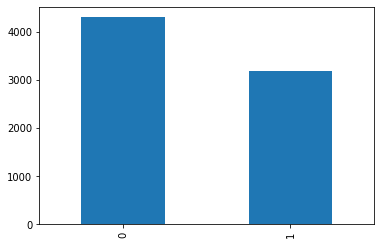

In [ ]:
train.target.value_counts().plot(kind='bar')

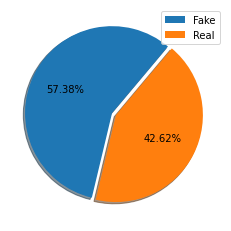

In [ ]:
plt.pie(train.target.value_counts(),
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=50)
plt.legend(['Fake', 'Real'])
plt.show()

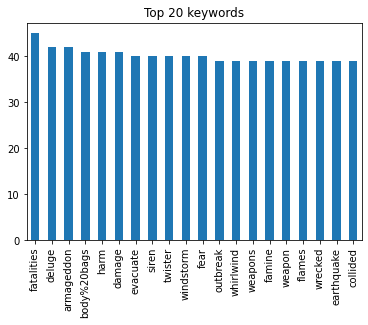

In [ ]:
train.keyword.value_counts()[:20].plot(kind='bar', title='Top 20 keywords')

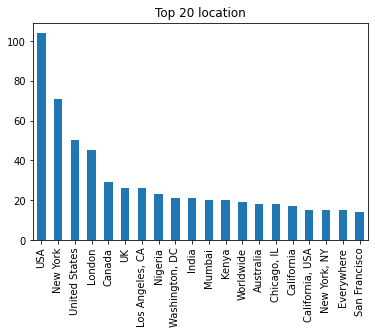

In [ ]:
train.location.value_counts()[:20].plot(kind='bar', title='Top 20 location')

In [ ]:
print(train.groupby('target').size().reset_index(name='count'))

   target  count
0       0   4305
1       1   3198


In [ ]:
re_list = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def removeing(text):
    re_html= re_list.sub('',text)
    return re_html

In [ ]:
train['text']=train['text'].apply(lambda x : removeing(x))
test['text']=test['text'].apply(lambda x : removeing(x))

In [ ]:
def cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()  
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)    
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x : cleaning(x))
test['text'] = test['text'].apply(lambda x : cleaning(x))

In [ ]:
def emojising(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
#예시
sentence="Its all about \U0001F300 face"
print(sentence)
emojising(sentence)

Its all about 🌀 face


'Its all about  face'

In [ ]:
train['text'] = train['text'].apply(lambda x : emojising(x))
test['text'] = test['text'].apply(lambda x : emojising(x))

In [ ]:
#train.drop("location", axis = 1, inplace = True)
#test.drop("location", axis = 1, inplace = True)

In [ ]:
#train.drop("keyword", axis = 1, inplace = True)
#test.drop("keyword", axis = 1, inplace = True)

In [ ]:
train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7604    worldnews fallen powerlines g link tram update...
7605    flip side walmart bomb everyone evacuate stay ...
7606    suicide bomber kills saudi security site mosqu...
7608    two giant cranes holding bridge collapse nearb...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7503, dtype: object

In [ ]:
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(train['text'])

In [ ]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 49),
 ('may', 88),
 ('allah', 7),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 249),
 ('near', 54)]

In [ ]:
vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12
#============================================================================
training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]
#=============================================================================
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
#=============================================================================
#train padding
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#test padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            514240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_4 (Dense)              (None, 14)                1806      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 15        
Total params: 565,725
Trainable params: 565,725
Non-trainable params: 0
_________________________________________________________________


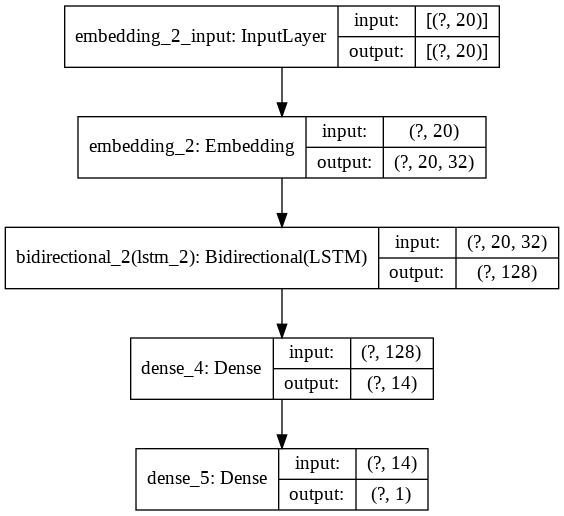

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
epoch = 10
history = model.fit(training_padded, training_labels, epochs=epoch, validation_data=(testing_padded, testing_labels))

Epoch 1/10
191/191 [==============================] - 5s 28ms/step - loss: 0.5509 - accuracy: 0.7128 - val_loss: 0.4723 - val_accuracy: 0.7870
Epoch 2/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2848 - accuracy: 0.8877 - val_loss: 0.5502 - val_accuracy: 0.7509
Epoch 3/10
191/191 [==============================] - 5s 25ms/step - loss: 0.1512 - accuracy: 0.9504 - val_loss: 0.6587 - val_accuracy: 0.7403
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1018 - accuracy: 0.9657 - val_loss: 0.6837 - val_accuracy: 0.7311
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.8683 - val_accuracy: 0.7424
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0701 - accuracy: 0.9778 - val_loss: 0.6859 - val_accuracy: 0.7219
Epoch 7/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0617 - accuracy: 0.9801 - val_loss: 0.6739 - val_accuracy: 0.7346

In [ ]:
model_df = pd.DataFrame(model.history.history)
model_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.550903,0.712808,0.472344,0.786978
1,0.284784,0.887685,0.550180,0.750885
2,0.151231,0.950410,0.658684,0.740269
3,0.101772,0.965681,0.683664,0.731069
4,0.079300,0.976026,0.868324,0.742392


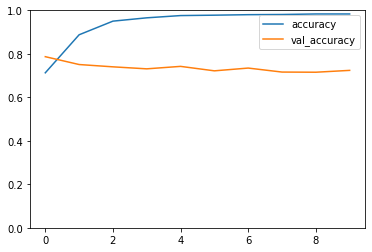

In [ ]:
model_df[['accuracy','val_accuracy']].plot(ylim=[0,1]);

In [ ]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
predictions = model.predict(testing_padded2)

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
submission['target'] = (predictions > 0.5).astype(int)
submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv("submission(LSTM).csv", index=False, header=True)

In [ ]:
def sentiment_predict(new_sentence):
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_length) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 'Real'입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 'Fake'입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict("Just happened a terrible car crash")

84.59% 확률로 'Fake'입니다.

